<a href="https://colab.research.google.com/github/rizanatlanta-dsproj/Stock-price-prediction/blob/main/stock1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01')

/tmp/ipython-input-3142132640.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [ ]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468254,72.528574,71.223252,71.476592,135480400
2020-01-03,71.763710,72.523738,71.539322,71.696152,146322800
2020-01-06,72.335564,72.374169,70.634547,70.885479,118387200
2020-01-07,71.995361,72.600968,71.775796,72.345212,108872000
2020-01-08,73.153481,73.455080,71.698566,71.698566,132079200
...,...,...,...,...,...
2025-12-19,273.670013,274.600006,269.899994,272.149994,144632000
2025-12-22,270.970001,273.880005,270.510010,272.859985,36571800


<Axes: xlabel='Date'>

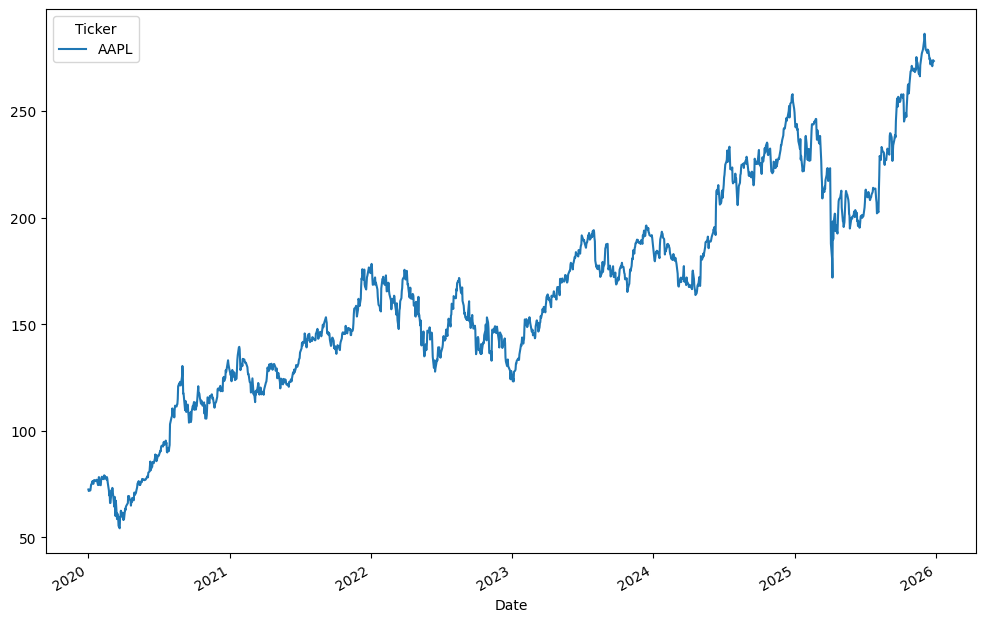

In [ ]:
df.Close.plot(figsize=(12, 8))

In [ ]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [ ]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.863156
2020-01-03,-1.877384
2020-01-06,-1.865835
2020-01-07,-1.872706
2020-01-08,-1.849317
...,...
2025-12-19,2.200117
2025-12-22,2.145591
2025-12-23,2.173661


In [ ]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
  data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [ ]:
data

array([[[-1.86315563],
        [-1.87738391],
        [-1.86583531],
        ...,
        [-1.76561196],
        [-1.72854118],
        [-1.73992153]],

       [[-1.87738391],
        [-1.86583531],
        [-1.87270571],
        ...,
        [-1.72854118],
        [-1.73992153],
        [-1.73953079]],

       [[-1.86583531],
        [-1.87270571],
        [-1.84931747],
        ...,
        [-1.73992153],
        [-1.73953079],
        [-1.76859194]],

       ...,

       [[ 2.11449008],
        [ 2.23202523],
        [ 2.19607812],
        ...,
        [ 2.17022853],
        [ 2.20011737],
        [ 2.14559058]],

       [[ 2.23202523],
        [ 2.19607812],
        [ 2.18557694],
        ...,
        [ 2.20011737],
        [ 2.14559058],
        [ 2.17366133]],

       [[ 2.19607812],
        [ 2.18557694],
        [ 2.17467145],
        ...,
        [ 2.14559058],
        [ 2.17366133],
        [ 2.20294435]]])

In [33]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [34]:
X_train

tensor([[[-1.8632],
         [-1.8774],
         [-1.8658],
         ...,
         [-1.7561],
         [-1.7656],
         [-1.7285]],

        [[-1.8774],
         [-1.8658],
         [-1.8727],
         ...,
         [-1.7656],
         [-1.7285],
         [-1.7399]],

        [[-1.8658],
         [-1.8727],
         [-1.8493],
         ...,
         [-1.7285],
         [-1.7399],
         [-1.7395]],

        ...,

        [[ 1.1079],
         [ 1.1097],
         [ 1.0936],
         ...,
         [ 1.3183],
         [ 1.3695],
         [ 1.3280]],

        [[ 1.1097],
         [ 1.0936],
         [ 1.1448],
         ...,
         [ 1.3695],
         [ 1.3280],
         [ 1.3354]],

        [[ 1.0936],
         [ 1.1448],
         [ 1.1470],
         ...,
         [ 1.3280],
         [ 1.3354],
         [ 1.3926]]])

In [35]:
y_train

tensor([[-1.7399],
        [-1.7395],
        [-1.7686],
        ...,
        [ 1.3354],
        [ 1.3926],
        [ 1.4223]])

In [24]:
class PredictionModel(nn.Module):

  def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
    super(PredictionModel, self).__init__()

    self.num_layers = num_layers
    self.hidden_dim = hidden_dim

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_dim, device=device)
    c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_dim, device=device)

    out, (hn, cn) = self.lstm(X, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :])

    return out

In [25]:
model = PredictionModel(input_dim=1, hidden_dim=32, output_dim=1, num_layers=2).to(device)

In [26]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [30]:
num_epochs = 200

for i in range(num_epochs):
  y_train_pred = model(X_train)

  loss = criterion(y_train_pred, y_train)

  if i % 25 == 0:
    print(i, loss.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


0 0.0028681866824626923
25 0.0028672772459685802
50 0.0028663810808211565
75 0.0028654925990849733
100 0.0028646059799939394
125 0.0028637151699513197
150 0.0028628166764974594
175 0.002861904911696911


In [54]:
model.eval()


y_train_pred_tensor = model(X_train)
y_test_pred_tensor = model(X_test)


y_train_pred_scaled = scaler.inverse_transform(y_train_pred_tensor.cpu().detach().numpy())
y_test_pred_scaled = scaler.inverse_transform(y_test_pred_tensor.cpu().detach().numpy())

y_train_actual_np = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
y_test_actual_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

y_train_actual_scaled = y_train_actual_np
y_test_actual_scaled = y_test_actual_np

In [55]:
train_rmse = root_mean_squared_error(y_train_actual_scaled, y_train_pred_scaled)
test_rmse = root_mean_squared_error(y_test_actual_scaled, y_test_pred_scaled)

In [56]:
train_rmse

2.648613214492798

In [57]:
test_rmse

7.71978235244751

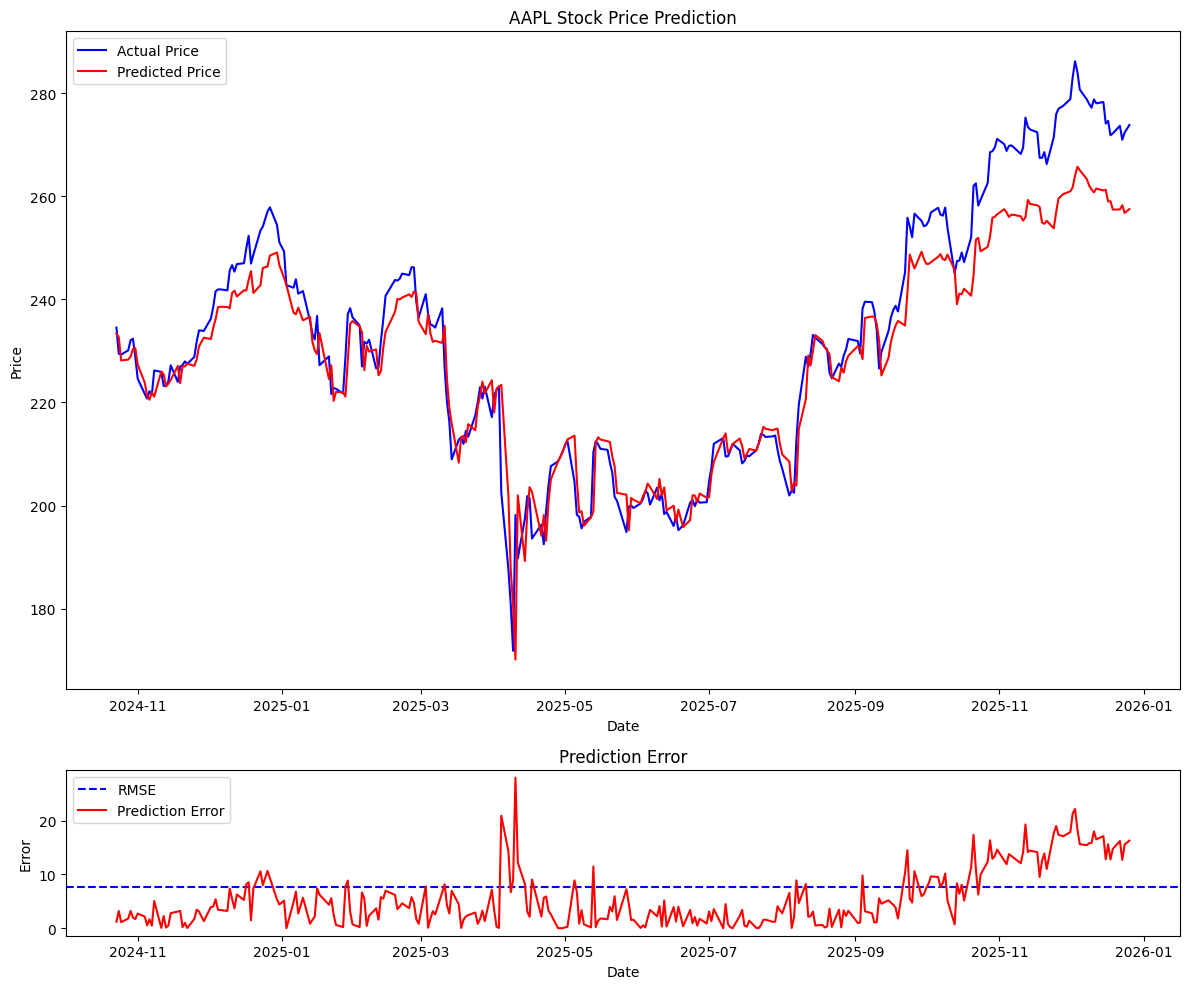

In [58]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4, 1)

axl = fig.add_subplot(gs[:3, 0])
axl.plot(df.iloc[-len(y_test_actual_scaled):].index, y_test_actual_scaled, color = 'blue', label = 'Actual Price')
axl.plot(df.iloc[-len(y_test_pred_scaled):].index, y_test_pred_scaled, color = 'red', label = 'Predicted Price')
axl.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label = 'RMSE')
ax2.plot(df.iloc[-len(y_test_actual_scaled):].index, abs(y_test_actual_scaled - y_test_pred_scaled), color = 'red', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

### Naive Baseline Model



In [62]:

y_test_naive_pred = X_test[:, -1, :].cpu().numpy()


y_test_naive_pred_scaled = scaler.inverse_transform(y_test_naive_pred)


naive_test_rmse = root_mean_squared_error(y_test_actual_scaled, y_test_naive_pred_scaled)

print(f'LSTM Test RMSE: {test_rmse:.2f}')
print(f'Naive Baseline Test RMSE: {naive_test_rmse:.2f}')

LSTM Test RMSE: 7.72
Naive Baseline Test RMSE: 4.09


### Visualizing Naive Baseline vs. LSTM vs. Actual


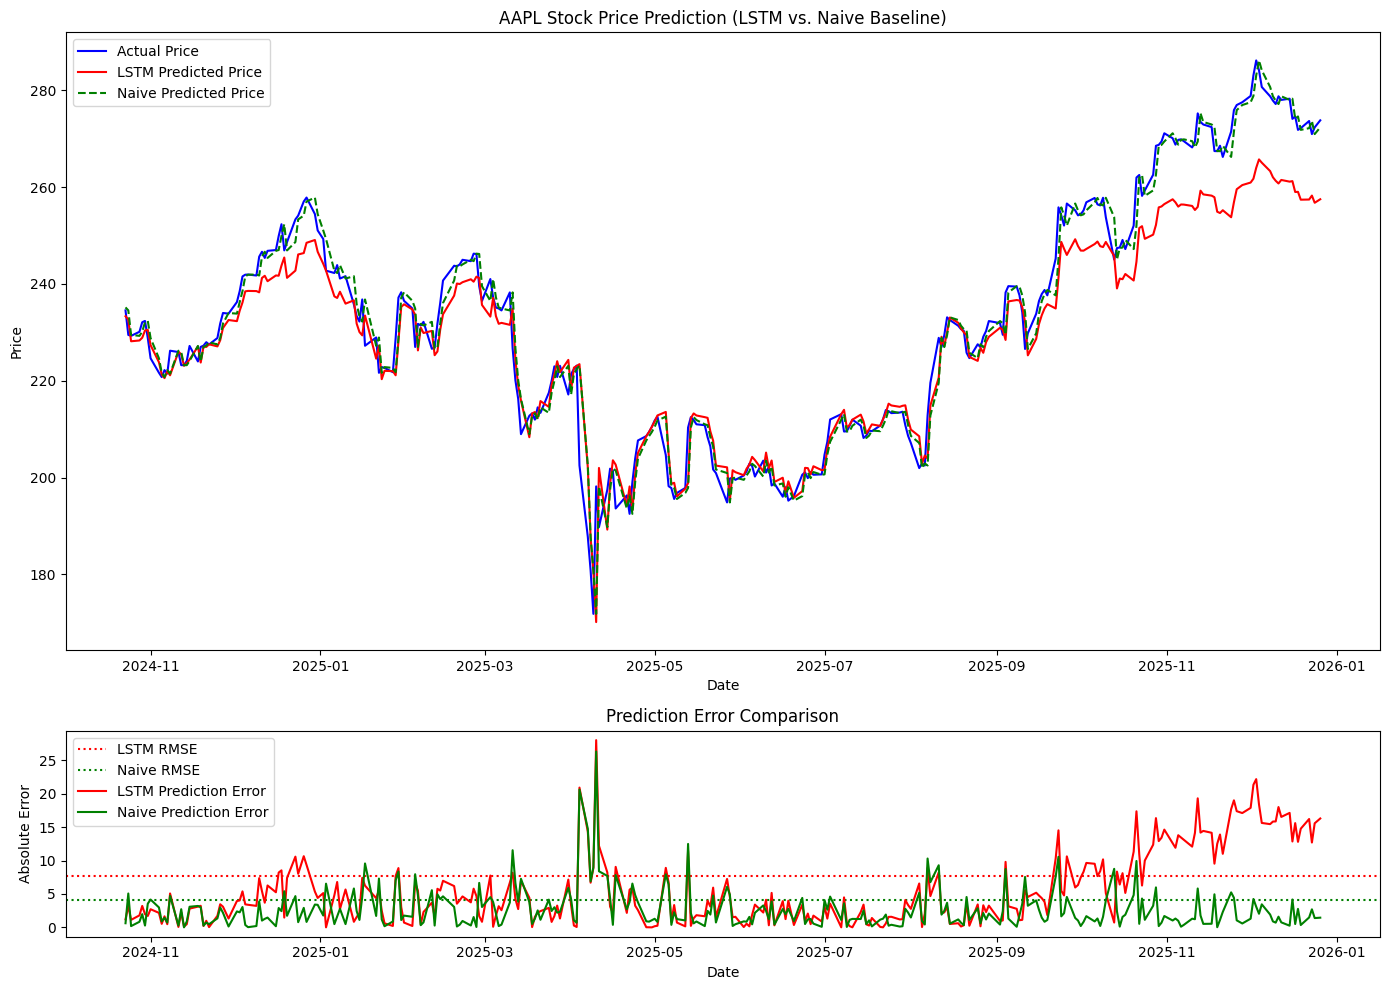

In [60]:
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df.iloc[-len(y_test_actual_scaled):].index, y_test_actual_scaled, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(y_test_pred_scaled):].index, y_test_pred_scaled, color='red', label='LSTM Predicted Price')
ax1.plot(df.iloc[-len(y_test_naive_pred_scaled):].index, y_test_naive_pred_scaled, color='green', linestyle='--', label='Naive Predicted Price')
ax1.legend()
ax1.set_title(f'{ticker} Stock Price Prediction (LSTM vs. Naive Baseline)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

ax2 = fig.add_subplot(gs[1, 0])
ax2.axhline(test_rmse, color='red', linestyle=':', label='LSTM RMSE')
ax2.axhline(naive_test_rmse, color='green', linestyle=':', label='Naive RMSE')
ax2.plot(df.iloc[-len(y_test_actual_scaled):].index, abs(y_test_actual_scaled - y_test_pred_scaled), color='red', label='LSTM Prediction Error')
ax2.plot(df.iloc[-len(y_test_actual_scaled):].index, abs(y_test_actual_scaled - y_test_naive_pred_scaled), color='green', label='Naive Prediction Error')
ax2.legend()
ax2.set_title('Prediction Error Comparison')
ax2.set_xlabel('Date')
ax2.set_ylabel('Absolute Error')

plt.tight_layout()
plt.show()

In [61]:
from sklearn.metrics import mean_absolute_error

lstm_test_mae = mean_absolute_error(y_test_actual_scaled, y_test_pred_scaled)
naive_test_mae = mean_absolute_error(y_test_actual_scaled, y_test_naive_pred_scaled)

print(f'LSTM Test MAE: {lstm_test_mae:.2f}')
print(f'Naive Baseline Test MAE: {naive_test_mae:.2f}')


LSTM Test MAE: 5.57
Naive Baseline Test MAE: 2.73


## Model Comparison Summary

To comprehensively evaluate the performance of the LSTM model against the Naive Baseline model, we consider both RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) metrics.

### Evaluation Metrics:
- **LSTM Test RMSE**: `7.72`
- **Naive Baseline Test RMSE**: `4.09`
- **LSTM Test MAE**: `5.57`
- **Naive Baseline Test MAE**: `2.73`



## Model Comparison Summary Table

| Metric              | LSTM Model | Naive Baseline Model |
| :------------------ | :--------- | :------------------- |
| **RMSE**            | 7.72       | 4.09                 |
| **MAE**             | 5.57       | 2.73                 |